In [1]:
%load_ext autoreload

In [2]:
%autoreload
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import matplotlib.pyplot as plt
import shapely
import re
from functools import reduce
import os
from shutil import copyfile

## Reading files

In [3]:
governorates = gpd.read_file('data/Admin/JOR_adm1.shp')
links = gpd.read_file('WEAP data/Transmission Links.kml')
groundwater = gpd.read_file('WEAP data/Groundwater.kml')
river_withdrawals = gpd.read_file('WEAP data/River Withdrawals.kml')
wwtp = gpd.read_file('WEAP data/Wastewater Treatment Plants.kml')
other_supply = gpd.read_file('WEAP data/Other Supplies.kml')
demand_sites = gpd.read_file('WEAP data/Demand Sites.kml')
tributary_inflows = gpd.read_file('WEAP data/Tributary Inflows.kml')
diversion_outflows = gpd.read_file('WEAP data/Diversion Outflows.kml')
diversion = gpd.read_file('WEAP data/Diversions.kml')

## Converting geometries and dropping unecesary columns

In [4]:
for gdf in [links, groundwater, river_withdrawals, wwtp, other_supply, 
            demand_sites, tributary_inflows, diversion, diversion_outflows]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

## Defining supply, demand points and transmitions

In [5]:
for gdf in [groundwater, river_withdrawals, wwtp, other_supply, 
            diversion_outflows]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

for gdf in [demand_sites, tributary_inflows]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Repojecting layers

In [6]:
PalestineBelt = 28192
for gdf in [links, groundwater, governorates, river_withdrawals, wwtp, 
            other_supply, demand_sites, tributary_inflows, diversion, 
            diversion_outflows]:
    gdf.to_crs(epsg=PalestineBelt, inplace=True)

## Defining types

In [7]:
groundwater['type'] = 'Groundwater supply'
river_withdrawals['type'] = 'River/pipeline supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
demand_sites['type'] = 'Demand site'
tributary_inflows['type'] = 'Tributary inflow'
diversion['type'] = 'Transmission Pipeline'
diversion_outflows['type'] = 'Diversion Outflow'

## Joining water transmition network points

In [8]:
points = tributary_inflows.append([diversion_outflows, river_withdrawals],
                                        ignore_index=True, sort=False)

## Processing raster information (water table depth and elevation)

In [9]:
def mask_raster(raster_path, mask_path, crs):
    with fiona.open(mask_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_image[out_image<0] = np.nan
        mask = (out_image!=0)
        out_image = fillnodata(out_image, mask)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "crs": crs})
    return out_image, out_meta

out_image, out_meta = mask_raster('data/Water Table Depth/Eurasia_model_wtd_v2.nc', 'data/Admin/JOR_adm0.shp', 'EPSG:4326')
    
with rasterio.open("data/Water Table Depth/Jordan WTD.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    
out_image, out_meta = mask_raster('data/DEM/DEM - Merged.tif', 'data/Admin/JOR_adm0.shp', 'EPSG:4326')
    
with rasterio.open("data/DEM/Jordan DEM.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    

In [10]:
dst_crs = f'EPSG:{PalestineBelt}' # CRS for web meractor 

def reproject_raster(raster_path, dst_crs, outpul_file):
    with rasterio.open(raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpul_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

reproject_raster('data/Water Table Depth/Jordan WTD.tif', dst_crs, 'data/Water Table Depth/Jordan_projected WTD.tif')
reproject_raster('data/DEM/Jordan DEM.tif', dst_crs, 'data/DEM/Jordan DEM - projected.tif')
reproject_raster('data/DEM/DEM - Merged.tif', dst_crs, 'data/DEM/DEM - Merged - projected.tif')

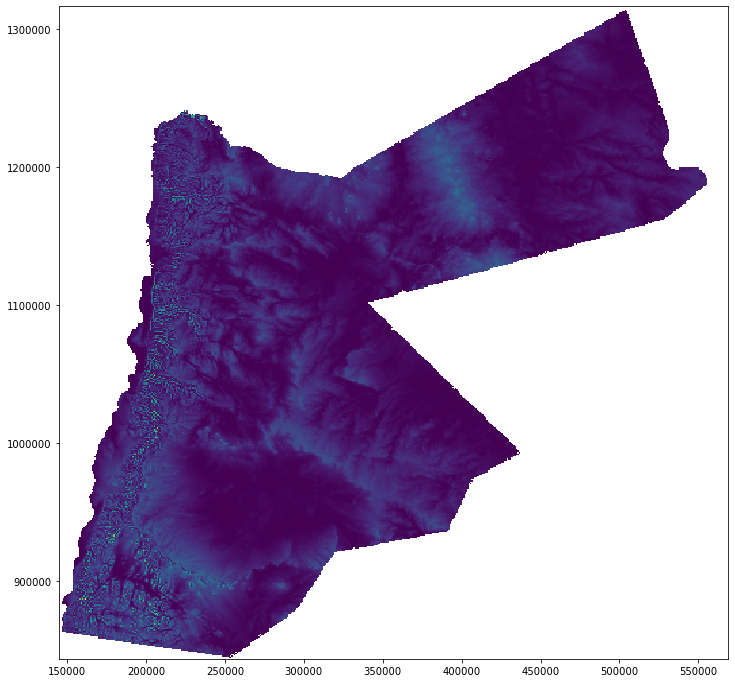

In [11]:
with rasterio.open("data/Water Table Depth/Jordan_projected WTD.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto')

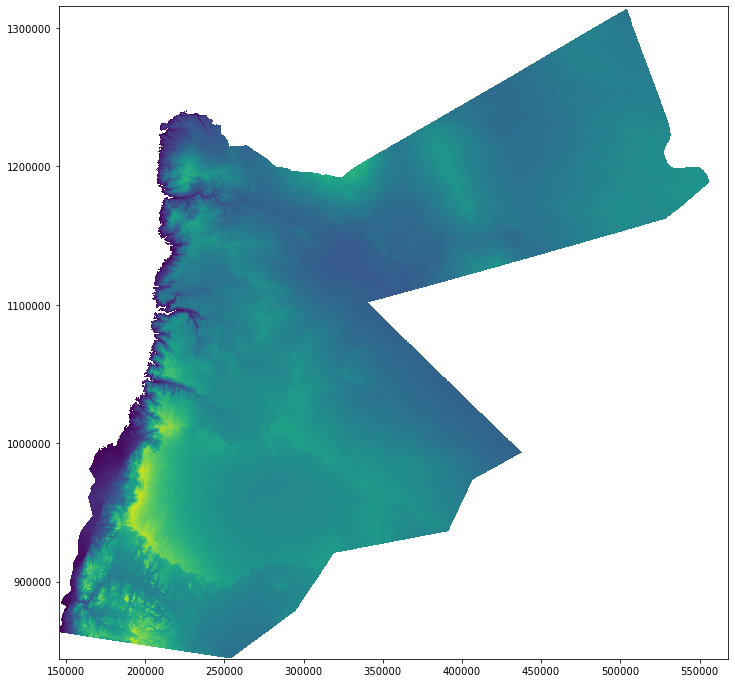

In [12]:
with rasterio.open("data/DEM/Jordan DEM - projected.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto')

## Calculate length of distribution and transmission links

In [13]:
links['length_m'] = links.length
diversion['pl_length_m'] = diversion.length

## Sampling raster data

In [14]:
with rasterio.open("data/Water Table Depth/Jordan_projected.tif") as src:
    groundwater['wtd_m'] = [float(val) for val in src.sample([(x.coords.xy[0][0], x.coords.xy[1][0]) for x in groundwater['geometry']])]

supply = groundwater.append([river_withdrawals, wwtp, other_supply], 
                            ignore_index=True, sort=False)
demand = gpd.sjoin(demand_sites, links, how='inner', op='intersects')
demand.drop(columns='index_right', inplace=True)
supply = gpd.sjoin(supply, links, how='inner', op='intersects')
supply.drop(columns='index_right', inplace=True)
    
with rasterio.open("data/DEM/DEM - Merged - projected.tif") as src:
    points['elevation_m'] = [float(val) for val in src.sample([(x.coords.xy[0][0], x.coords.xy[1][0]) for x in points['geometry']])]
    demand['elevation_m'] = [float(val) for val in src.sample([(x.coords.xy[0][0], x.coords.xy[1][0]) for x in demand['geometry']])]
    supply['elevation_m'] = [float(val) for val in src.sample([(x.coords.xy[0][0], x.coords.xy[1][0]) for x in supply['geometry']])]
        

In [15]:
supply.loc[supply.point=='RedDead', 'type'] = 'Desalination'
supply.loc[supply.point=='Aqaba Desal', 'type'] = 'Desalination'

## Intersect distribution links with supply and demand

In [16]:
distribution = gpd.sjoin(links, supply, how='inner', op='intersects')
distribution.drop(columns='index_right', inplace=True)
distribution = gpd.sjoin(distribution, demand, how='inner', op='intersects')
distribution.drop(columns='index_right', inplace=True)
distribution['type'] = 'Distribution link'

## Plotting the system

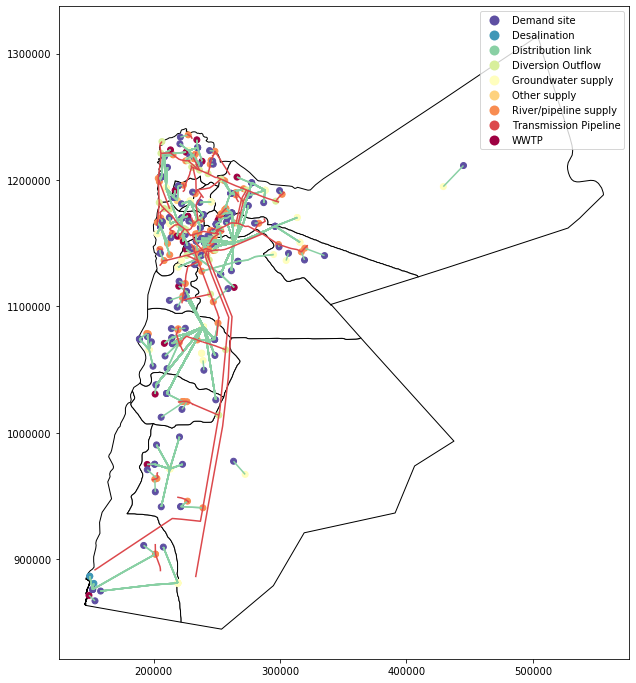

In [17]:
base = governorates.plot(color='white', edgecolor='black', figsize=(12, 12))
data = distribution.append([supply, demand, diversion, diversion_outflows], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [18]:
points_coords = points.geometry.unary_union
list_gdf = []
i = 0

for pipeline in diversion.iterrows():
    split_pipeline = shapely.ops.split(pipeline[1].geometry, points_coords)
    segments = [feature for feature in split_pipeline]
    index = list(range(i, len(segments) + i))
    gdf_segments = gpd.GeoDataFrame(index, geometry=segments)
    gdf_segments.columns = ['index', 'geometry']
    gdf_segments['pipeline'] = pipeline[1].diversion
    gdf_segments['pl_length_m'] = pipeline[1].pl_length_m
    gdf_segments.crs = {'init': f'epsg:{PalestineBelt}', 'no_defs': True}
    intersections = gpd.sjoin(gdf_segments, points, how='inner', op='intersects')
    list_gdf.append(intersections)
    i = list_gdf[-1]['index'].max() + 1

In [19]:
df_pl = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True))
df_pl['segment_length_m'] = df_pl.length
# df.drop('index', axis=1, inplace=True)
df_pl.crs = supply.crs

In [20]:
gdf_new = gpd.GeoDataFrame()
x = []
# df_pl.reset_index(inplace = True, drop=True)
for name in df_pl.pipeline.unique():
    _df = df_pl.loc[df_pl.pipeline==name].copy()
    for index in _df['index'].unique():
        _df2 = _df.loc[df_pl['index']==index]
        if _df2.shape[0] == 1:
            x.append(_df2.index.values[0])

In [21]:
df_pl.loc[df_pl.index.isin(x) & (df_pl.pipeline=='KAC')]

,index,geometry,pipeline,pl_length_m,index_right,point,type,elevation_m,segment_length_m
327,187,"LINESTRING (202897.306 1166419.048, 202911.361...",KAC,64349.75759,203,KAC2BQ_AgriJV,River/pipeline supply,-312.0,2548.862159


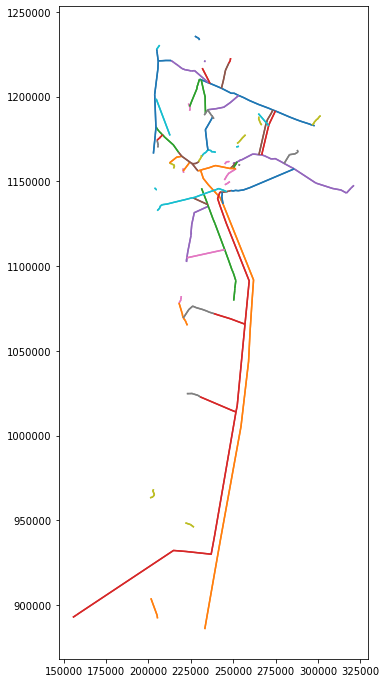

In [22]:
df_pl.loc[~df_pl.index.isin(x)].plot(figsize=(12,12), column='pipeline', categorical=True)

In [23]:
def extract_weap(results, spacial_data, points, melt_on, regex):
    df = pd.DataFrame()
    for key, row in spacial_data.groupby(points):
        df_temp = results.filter(regex=regex.format(key)).copy()
        df_temp.columns = [i.split('\\')[-1] for i in df_temp.columns]
        df_temp[points] = key
        for i in melt_on:
            df_temp[i] = results[i]
        melt_vars = melt_on.copy()
        melt_vars.append(points)
        df = df.append(df_temp.melt(id_vars=melt_vars), sort=False)
    return df.reset_index(drop=True)

In [24]:
def extract(s, left, rigth):
    mo = re.search(f'{left}(.*){rigth}', s)
    if mo:
        return mo.group(1)
    return ''

In [25]:
def get_demand_data(sheet_names, data, spatial_data, variable, regex):
    merged_data = pd.DataFrame()
    for sheet_name, value in sheet_names.items():
        data_temp = data.parse(sheet_name, skiprows=5)
        data_temp.rename(columns={'$Columns = Year': 'Year', ' Timestep': 'Month'}, inplace=True)
        data_temp.columns = data_temp.columns.str.replace('"', '')
        merged_data_temp = extract_weap(data_temp, spatial_data, variable, ['Year','Month'], regex)
        merged_data_temp['units'] = [extract(s, '\[','\]') for s in merged_data_temp.variable]
        merged_data_temp['variable'] = [i.split('[')[0] for i in merged_data_temp.variable]
        merged_data_temp['type'] = value
        merged_data_temp.loc[merged_data_temp['type']=='variable', 'type'] = merged_data_temp.loc[merged_data_temp['type']=='variable', 'variable']

        merged_data = merged_data.append(merged_data_temp, sort=False)
        
    return merged_data

In [26]:
def enumerate_segments():
    x = len(pl_flow.Year.unique())*12
    pl_flow['n'] = 0
    for key, group in pl_flow.groupby('pipeline'):
        n = [[i]*x for i in range(int(group.shape[0]/x))]
        n = reduce(lambda a, b: a + b, n)
        pl_flow.loc[pl_flow.pipeline==key,'n'] = n

In [27]:
def get_elevation_delta():  
    pl_flow['elevation_delta'] = 0
    for pipeline in pl_flow.pipeline.unique():
        for n in range(pl_flow.loc[pl_flow.pipeline==pipeline, 'n'].max()):
            elevation_1 = pl_flow.loc[(pl_flow.pipeline==pipeline) & (pl_flow.n==n), 'elevation']
            elevation_2 = pl_flow.loc[(pl_flow.pipeline==pipeline) & (pl_flow.n==(n+1)), 'elevation']
            pl_flow.loc[(pl_flow.pipeline==pipeline) & (pl_flow.n==n), 'elevation_delta'] = np.array(elevation_2) - np.array(elevation_1)

In [28]:
files_dict = {'Reference': {'Eto trend': ['DataExchange - Reference.xlsm'], 
                            'Without Eto trend': ['DataExchange - Reference - No ETo Trend.xlsm']},
              'Improve AG eff': {'Eto trend': ['DataExchange - Improve AG eff by 10percent.xlsm',
                                               'DataExchange - Improve AG eff by 20percent.xlsm'], 
                                 'Without Eto trend': ['DataExchange - Improve AG eff by 10percent - No ETo Trend.xlsm',
                                                       'DataExchange - Improve AG eff by 20percent - No ETo Trend.xlsm']},
              'New Resources': {'Eto trend': ['DataExchange - New Resources.xlsm'], 
                                'Without Eto trend': ['DataExchange - New Resources - No ETo Trend.xlsm']},
              'Reduce NRW': {'Eto trend': ['DataExchange - Reduce NRW to 40 percent.xlsm', 
                                           'DataExchange - Reduce NRW to 20 percent.xlsm'], 
                             'Without Eto trend': ['DataExchange - Reduce NRW to 40 percent - No ETo Trend.xlsm',
                                                   'DataExchange - Reduce NRW to 20 percent - No ETo Trend.xlsm',]}}

def create_folder(path):
    if not os.path.exists(path):
        os.mkdir(path)

raw_data = os.path.join('WEAP data', 'Dec 08')
results_path = os.path.join('WEAP data', 'Results')
create_folder(results_path)
for scenario, files in files_dict.items():
    scenario_path = os.path.join(results_path, scenario)
    create_folder(scenario_path)
    for folder, file in files.items():
        folder_path = os.path.join(scenario_path, folder)
        create_folder(folder_path)
        for i, f in enumerate(file):
            dst = os.path.join(folder_path, f'level_{i+1}')
            create_folder(dst)
            copyfile(os.path.join(raw_data, f), os.path.join(dst, 'results.xlsm'))

In [55]:
scenarios = ['Reference', 'Improve AG eff', 'New Resources', 'Reduce NRW']
# scenarios = ['Reference']
processed_data = os.path.join('WEAP data', 'Processed data')
for scenario in scenarios:
    scenario_folder = os.path.join(results_path, scenario)
    create_folder(os.path.join(processed_data, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(processed_data, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(processed_data, scenario, sub_scenario, level)
            create_folder(output_folder)
            file = os.path.join(sub_scenario_folder, level, 'results.xlsm')
            data = pd.ExcelFile(file)

            sheet_names = {'Supply Requirement_AG': 'Agriculture', 
                           'Supply Requirement_Muni': 'Municipality', 
                           'Supply Requirement_Ind': 'Industry'}
            required_demand = get_demand_data(sheet_names, data, demand, 'point', '^ {}')
            required_demand['elevation_m'] = required_demand.point.map(demand.groupby('point')['elevation_m'].mean())

            demand['type'] = demand.point.map(required_demand.groupby('point').agg({'type': 'first'}).type)

            sheet_names = {'Supply Delivered_AG': 'Agriculture', 
                           'Supply Delivered_Muni': 'Municipality', 
                           'Supply Delivered_Ind': 'Industry'}
            delivered_demand = get_demand_data(sheet_names, data, demand, 'point', '^ {}')
            delivered_demand['elevation_m'] = delivered_demand.point.map(demand.groupby('point')['elevation_m'].mean())

            demand.loc[demand['type'].isna(), 'type'] = demand.loc[demand['type'].isna(), 'point'].map(delivered_demand.groupby('point').agg({'type': 'first'}).type)

            sheet_names = {'RedDead': 'Desalination'}
            red_dead = get_demand_data(sheet_names, data, supply, 'point', '{}')
            red_dead = red_dead.append(get_demand_data(sheet_names, data, demand, 'point', '{}'))
            red_dead['point'] = 'RedDead'
            sheet_names = {'Aqaba Desal': 'Desalination'}
            aqaba_desal = get_demand_data(sheet_names, data, demand, 'point', '{}')
            aqaba_desal['point'] = 'Aqaba Desal'
            desalination = red_dead.append(aqaba_desal)
            desalination['value'] = abs(desalination['value'])
            desalination['variable'] = desalination.variable.str.strip()
            
            sheet_names = {'GW Pumping': 'Groundwater supply'}
            gw_demand =  get_demand_data(sheet_names, data, groundwater, 'point', '^ {}')
            gw_demand['wtd_m'] = gw_demand.point.map(groundwater.groupby('point')['wtd_m'].mean())

            sheet_names = {'Groundwater': 'Thickness'}
            gw_thickness =  get_demand_data(sheet_names, data, supply, 'point', '^ {}')
            gw_thickness.rename(columns={'value': 'thickness', 'units': 'thickness_units'}, inplace=True)
            gw_thickness.drop(columns='type', inplace=True)

            for point in gw_thickness.point.unique():
                _filter = (gw_thickness.point==point)
                init_thickness = gw_thickness.loc[_filter].iloc[0].thickness
                gw_thickness.loc[_filter, 'wtd'] = init_thickness - gw_thickness.loc[_filter, 'thickness'] + \
                                                   float(groundwater.loc[groundwater.point==point,'wtd_m'])
            gw_demand = gw_demand.merge(gw_thickness, on=['Year','Month','point','variable'])

            sheet_names = {'Wadis': 'River/pipeline supply'}
            surface_water =  get_demand_data(sheet_names, data, supply, 'point', '{}')

            sheet_names = {'WWTP Inflow': 'WWTP'}
            wwtp_inflow =  get_demand_data(sheet_names, data, supply, 'point', '^ {}')

            pl_flow = pd.DataFrame()

            for sheet_name in ['Pipelines', 'PumpStations']:
                pl_data = data.parse(sheet_name, skiprows=5)
                pl_data.rename(columns={'$Columns = Year': 'Year', ' Timestep': 'Month'}, inplace=True)
                pl_data.columns = pl_data.columns.str.replace('"', '')
                pl_data.columns = pl_data.columns.str.replace('  ', ' ')
                pl_data.columns = pl_data.columns.str.strip()
                if sheet_name == 'Pipelines':
                    pl_data["PL_ZaraMain2SZ09SZ06 0 \ Reach[Cubic Meter]"] = pl_data["PL_ZaraMain2SZ09SZ06 0 \ Headflow[Cubic Meter]"]

                df_pl_temp = extract_weap(pl_data, df_pl, 'pipeline', ['Year','Month'], '^{} [0-9]')
                df_pl_temp['units'] = [extract(s, '\[', '\]') for s in df_pl_temp.variable]
                df_pl_temp['variable'] = [(i).split('[')[0].strip() for i in df_pl_temp.variable]

                pl_flow = pl_flow.append(df_pl_temp, sort=False)

            
            pl_flow = pl_flow.loc[~pl_flow.variable.str.contains('FR')]

            pl_flow['point'] = np.nan
            _vec = ~pl_flow.variable.isin(['Headflow','Reach'])
            pl_flow.loc[_vec,'point'] = pl_flow.loc[_vec,'variable']

            _df = pl_flow.loc[(pl_flow.Year==2020) & (pl_flow.Month==1)].groupby('pipeline').count()
            idx = _df.loc[_df.point<3].index
            _df = pl_flow.loc[pl_flow.pipeline.isin(idx)].copy()
               

            for pipeline in _df.pipeline.unique():
                for row in df_pl.loc[df_pl.pipeline==pipeline].iterrows():
                    if (row[1].point not in _df.loc[(_df.pipeline==pipeline), 'variable'].unique()) & (row[1].type=='Diversion Outflow'):
                        pl_flow.loc[(pl_flow.pipeline==pipeline) & (pl_flow.variable=='Headflow'), 'point'] = row[1].point
                    elif (row[1].point not in _df.loc[(_df.pipeline==pipeline), 'variable'].unique()) & (row[1].type=='Tributary inflow'):
                            pl_flow.loc[(pl_flow.pipeline==pipeline) & (pl_flow.variable=='Reach'), 'point'] = row[1].point

            
            _df = df_pl[['pipeline','point','index']].groupby(['pipeline','point']).mean()
            # _df = _df.reset_index().set_index('point')
            _pl_flow = pl_flow.set_index(['pipeline','point'])
            _index = _pl_flow.index.map(_df['index'].to_dict())
            pl_flow['pl_index'] = [(i + 0.5) if i%1==0.5 else (i) for i in _index]
            pl_flow['elevation'] = pl_flow.point.map(df_pl.groupby('point')['elevation_m'].mean().to_dict())
            pl_flow['segment_length'] = pl_flow.pl_index.map(df_pl.groupby('index')['segment_length_m'].mean().to_dict())
            pl_flow['pipeline_length'] = pl_flow.pipeline.map(df_pl.groupby('pipeline')['pl_length_m'].mean().to_dict())

            pl_flow.dropna(subset=['point'], inplace=True)
            

            enumerate_segments()
            get_elevation_delta()

            pl_flow.loc[(pl_flow.variable=='Reach') & (pl_flow.elevation_delta!=0), 'point'] = np.nan
            pl_flow.dropna(subset=['point'], inplace=True)
            

            enumerate_segments()
            get_elevation_delta()

            _point = supply.loc[supply['type']=='River/pipeline supply'].point.unique()
#             _pipe = pl_flow.loc[pl_flow['point'].isin(_point)].pipeline.unique()
            _pipe = pl_flow.pipeline.unique()
            pl_flow['water_use'] = 0
            for pipe in _pipe:
#                 n = pl_flow.loc[(pl_flow['pipeline']==pipe) & pl_flow['point'].isin(_point)].n.unique()
                n = pl_flow.loc[(pl_flow['pipeline']==pipe)].n.unique()
                for _n in range(1,n.max()+1):
                    
                    value2 = np.array(pl_flow.loc[(pl_flow['pipeline']==pipe) & (pl_flow['n']==_n), 'value'])
                    value1 = np.array(pl_flow.loc[(pl_flow['pipeline']==pipe) & (pl_flow['n']==(_n-1)), 'value'])
                    pl_flow.loc[(pl_flow['pipeline']==pipe) & (pl_flow['n']==_n), 'water_use'] = abs(value1 - value2)
                
                if pl_flow.loc[(pl_flow['pipeline']==pipe)].water_use.sum() == 0:
                    pl_flow.loc[(pl_flow['pipeline']==pipe), 'water_use'] = \
                                                    pl_flow.loc[(pl_flow['pipeline']==pipe), 'value'].mean()/\
                                                    pl_flow.loc[(pl_flow['pipeline']==pipe), 'value'].count()
            
            
            pl_flow['type'] = np.nan
            pl_flow.loc[pl_flow['point'].isin(_point), 'type'] = 'River/pipeline supply'
            
            desalination.to_csv(os.path.join(output_folder, 'Desalination.csv'), index=False)
            wwtp_inflow.to_csv(os.path.join(output_folder, 'WWTP_inflow.csv'), index=False)
            surface_water.to_csv(os.path.join(output_folder, 'Surface_water_supply.csv'), index=False)
            gw_demand.to_csv(os.path.join(output_folder, 'Groundwater_supply.csv'), index=False)
            delivered_demand.to_csv(os.path.join(output_folder, 'Delivered_demand.csv'), index=False)
            required_demand.to_csv(os.path.join(output_folder, 'Required_demand.csv'), index=False)
            pl_flow.to_csv(os.path.join(output_folder, 'Pipelines_flow.csv'), index=False)
            

In [30]:
folder = r'dashboard/spatial_data/'
demand.to_file(f'{folder}Demand_points.geojson', driver='GeoJSON')
supply.to_file(f'{folder}Supply_points.geojson', driver='GeoJSON')
df_pl.to_file(f'{folder}Pipelines.geojson', driver='GeoJSON')